# Segmentation Algorithm Workflows

This notebook demonstrates IceFloeTracker.jl's segmentation algorithms 
with very basic examples of their use.

In [ ]:
# Setup environment
using Pkg
Pkg.add("IceFloeTracker")
Pkg.add("Images")

In [5]:
# Load packages
using IceFloeTracker: LopezAcosta2019, LopezAcosta2019Tiling, Watkins2026Dataset, metadata, modis_truecolor, modis_landmask, modis_falsecolor, validated_binary_floes
using Images: erode, segment_mean, labels_map, SegmentedImage, RGB, mosaicview

## Load the images

Load the dataset from [https://github.com/danielmwatkins/ice_floe_validation_dataset](https://github.com/danielmwatkins/ice_floe_validation_dataset) using the `Watkins2026Dataset` data loader.

In [6]:
full_dataset = Watkins2026Dataset(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")

┌ Warning: In /tmp/Watkins2026/a451cd5e62a10309a9640fbbe6b32a236fcebc70/data/validation_dataset/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse /home/vscode/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


IceFloeTracker.Data.Dataset(IceFloeTracker.Data.GitHubLoader("https://github.com/danielmwatkins/ice_floe_validation_dataset/", "a451cd5e62a10309a9640fbbe6b32a236fcebc70", "/tmp/Watkins2026"), 378×28 DataFrame
 Row │ case_number  region          start_date  center_lon  center_lat  center ⋯
     │ Int64        String          Dates.Date  Float64     Float64     Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           1  baffin_bay      2022-09-11    -91.5275     77.801    -9625 ⋯
   2 │           1  baffin_bay      2022-09-11    -91.5275     77.801    -9625
   3 │           2  baffin_bay      2015-03-12    -81.9643     76.0579   -9125
   4 │           2  baffin_bay      2015-03-12    -81.9643     76.0579   -9125
   5 │           3  baffin_bay      2012-04-19    -79.5793     75.6372   -8875 ⋯
   6 │           3  baffin_bay      2012-04-19    -79.5793     75.6372   -8875
   7 │           4  baffin_bay      2019-09-25    -76.8094     79.3029

The available data are listed in the metadata field:

In [7]:
first(metadata(full_dataset), 10)

10×28 DataFrame
 Row │ case_number  region      start_date  center_lon  center_lat  center_x   ⋯
     │ Int64        String      Dates.Date  Float64     Float64     Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           1  baffin_bay  2022-09-11    -91.5275     77.801    -962500   ⋯
   2 │           1  baffin_bay  2022-09-11    -91.5275     77.801    -962500
   3 │           2  baffin_bay  2015-03-12    -81.9643     76.0579   -912500
   4 │           2  baffin_bay  2015-03-12    -81.9643     76.0579   -912500
   5 │           3  baffin_bay  2012-04-19    -79.5793     75.6372   -887500   ⋯
   6 │           3  baffin_bay  2012-04-19    -79.5793     75.6372   -887500
   7 │           4  baffin_bay  2019-09-25    -76.8094     79.3029   -612500
   8 │           4  baffin_bay  2019-09-25    -76.8094     79.3029   -612500
   9 │           5  baffin_bay  2013-03-08    -74.8142     78.2037   -637500   ⋯
  10 │           5  baffin_bay  2013-03-08    -74.8142     78.2037   -637500
                                                              22 columns omitted

For the example, we choose a single case from Baffin Bay in May 2022.

In [8]:
dataset = filter(c-> c.case_number == 6 && c.satellite == "terra", full_dataset)
case = first(dataset)

IceFloeTracker.Data.Case(IceFloeTracker.Data.GitHubLoader("https://github.com/danielmwatkins/ice_floe_validation_dataset/", "a451cd5e62a10309a9640fbbe6b32a236fcebc70", "/tmp/Watkins2026"), DataFrameRow
 Row │ case_number  region      start_date  center_lon  center_lat  center_x   ⋯
     │ Int64        String      Dates.Date  Float64     Float64     Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           6  baffin_bay  2022-05-30    -73.3612     75.2608   -762500   ⋯
                                                              22 columns omitted)

The data include the true-color image:

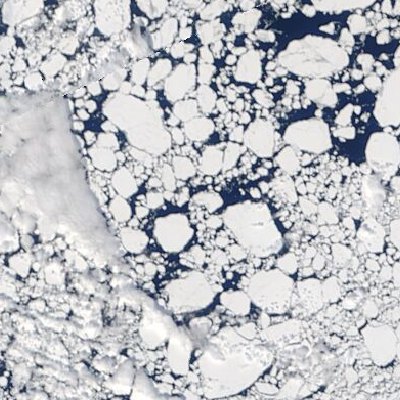

In [9]:
truecolor = modis_truecolor(case)

... a false-color image:

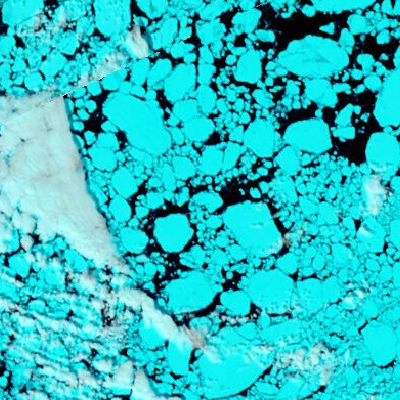

In [10]:
falsecolor = modis_falsecolor(case)

... and a landmask, which in this particular case is empty:

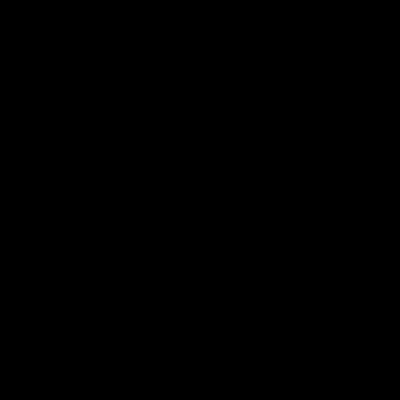

In [11]:
landmask = modis_landmask(case)

## Run the segmentation algorithm

The segmentation algorithm is an object with parameters as follows:

In [12]:
segmentation_algorithm = LopezAcosta2019.Segment()

IceFloeTracker.LopezAcosta2019.Segment(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

If we wanted to modify the options, we could include those in the call above. 
See the documentation for `LopezAcosta2019.Segment` for details.
The default parameters are as follows:

In [13]:
dump(segmentation_algorithm)

IceFloeTracker.LopezAcosta2019.Segment
  landmask_structuring_element: Array{Bool}((99, 99)) Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]


Run the algorithm as follows:

In [24]:
segments = segmentation_algorithm(RGB.(truecolor), RGB.(falsecolor), landmask)

┌ Info: building landmask
└ @ IceFloeTracker.LopezAcosta2019 /workspaces/IceFloeTracker.jl/src/Pipeline/LopezAcosta2019.jl:78
┌ Info: Building cloudmask
└ @ IceFloeTracker.LopezAcosta2019 /workspaces/IceFloeTracker.jl/src/Pipeline/LopezAcosta2019.jl:81
┌ Info: Finding ice labels
└ @ IceFloeTracker.LopezAcosta2019 /workspaces/IceFloeTracker.jl/src/Pipeline/LopezAcosta2019.jl:86
┌ Info: Sharpening truecolor image
└ @ IceFloeTracker.LopezAcosta2019 /workspaces/IceFloeTracker.jl/src/Pipeline/LopezAcosta2019.jl:89
┌ Info: Normalizing truecolor image
└ @ IceFloeTracker.LopezAcosta2019 /workspaces/IceFloeTracker.jl/src/Pipeline/LopezAcosta2019.jl:97
┌ Info: Discriminating ice/water
└ @ IceFloeTracker.LopezAcosta2019 /workspaces/IceFloeTracker.jl/src/Pipeline/LopezAcosta2019.jl:103
┌ Info: Segmenting floes part 1/3
└ @ IceFloeTracker.LopezAcosta2019 /workspaces/IceFloeTracker.jl/src/Pipeline/LopezAcosta2019.jl:109
┌ Info: Segmenting floes part 2/3
└ @ IceFloeTracker.LopezAcosta2019 /workspaces

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 59

To show the results with each segment marked using its mean color:

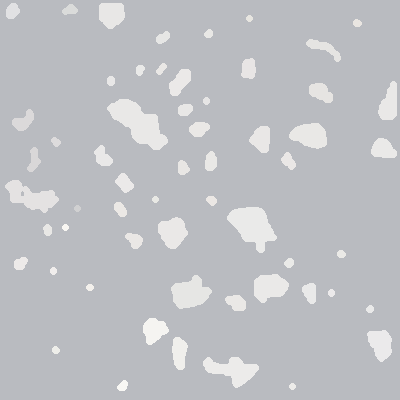

In [25]:
map(i -> segment_mean(segments, i), labels_map(segments))

We can do the same with the falsecolor image:

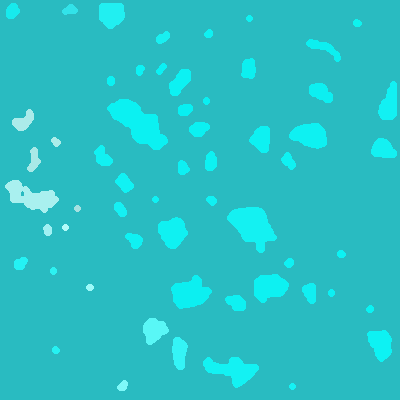

In [26]:
# Get the labels_map
segments_falsecolor = SegmentedImage(falsecolor, labels_map(segments))
map(i -> segment_mean(segments_falsecolor, i), labels_map(segments_falsecolor))

Let's compare the segmented output to the manually validated labels:

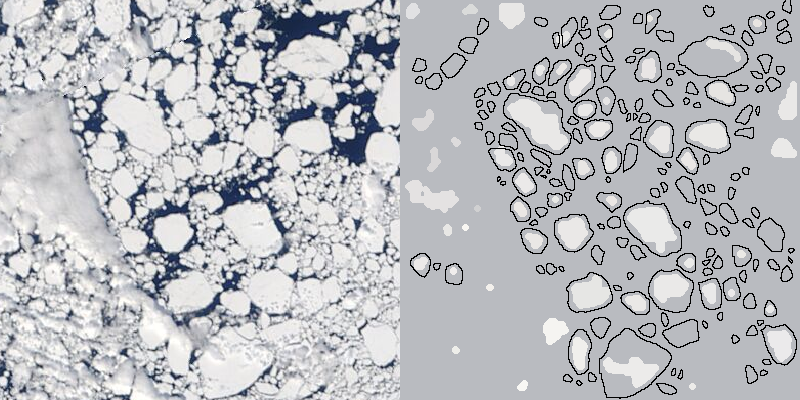

In [27]:
man_labels = validated_binary_floes(case)
outlines = man_labels .- erode(man_labels)
seg_vs = map(i -> segment_mean(segments, i), labels_map(segments))
mosaicview(truecolor, seg_vs .* (1 .- Float64.(outlines)), nrow=1)

## Run the segmentation algorithm with tiling
The "tiling" version of the algorithm is an object:

In [28]:
segmentation_algorithm_with_tiling = LopezAcosta2019Tiling.Segment()

IceFloeTracker.LopezAcosta2019Tiling.Segment((rblocks = 2, cblocks = 2), (prelim_threshold = 0.43137254901960786, band_7_threshold = 0.7843137254901961, band_2_threshold = 0.7450980392156863, ratio_lower = 0.0, ratio_offset = 0.0, ratio_upper = 0.75), (white_threshold = 25.5, entropy_threshold = 4, white_fraction_threshold = 0.4), (gamma = 1.5, gamma_factor = 1.3, gamma_threshold = 220), (se_disk1 = Bool[0 1 0; 1 1 1; 0 1 0], se_disk2 = Bool[0 0 … 0 0; 0 1 … 1 0; … ; 0 1 … 1 0; 0 0 … 0 0], se_disk4 = Bool[0 0 … 0 0; 0 1 … 1 0; … ; 0 1 … 1 0; 0 0 … 0 0]), (radius = 10, amount = 2.0, factor = 255.0), (band_7_threshold = 0.0196078431372549, band_2_threshold = 0.9019607843137255, band_1_threshold = 0.9411764705882353, band_7_threshold_relaxed = 0.0392156862745098, band_1_threshold_relaxed = 0.7450980392156863, possible_ice_threshold = 0.29411764705882354, k = 3), (radius = 10, amount = 2, factor = 0.5), 0.1)

It has more configurable parameters. 
For details, see the documentation of `LopezAcosta2019Tiling.Segment`.
The default parameters are as follows:

In [29]:
dump(segmentation_algorithm_with_tiling)

IceFloeTracker.LopezAcosta2019Tiling.Segment
  tile_settings: @NamedTuple{rblocks::Int64, cblocks::Int64}
    rblocks: Int64 2
    cblocks: Int64 2
  cloud_mask_thresholds: @NamedTuple{prelim_threshold::Float64, band_7_threshold::Float64, band_2_threshold::Float64, ratio_lower::Float64, ratio_offset::Float64, ratio_upper::Float64}
    prelim_threshold: Float64 0.43137254901960786
    band_7_threshold: Float64 0.7843137254901961
    band_2_threshold: Float64 0.7450980392156863
    ratio_lower: Float64 0.0
    ratio_offset: Float64 0.0
    ratio_upper: Float64 0.75
  adapthisteq_params: @NamedTuple{white_threshold::Float64, entropy_threshold::Int64, white_fraction_threshold::Float64}
    white_threshold: Float64 25.5
    entropy_threshold: Int64 4
    white_fraction_threshold: Float64 0.4
  adjust_gamma_params: @NamedTuple{gamma::Float64, gamma_factor::Float64, gamma_threshold::Int64}
    gamma: Float64 1.5
    gamma_factor: Float64 1.3
    gamma_threshold: Int64 220
  structuring_elemen

In [20]:
segments = segmentation_algorithm_with_tiling(truecolor, falsecolor, landmask)

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 348

To show the results with each segment marked using its mean color:

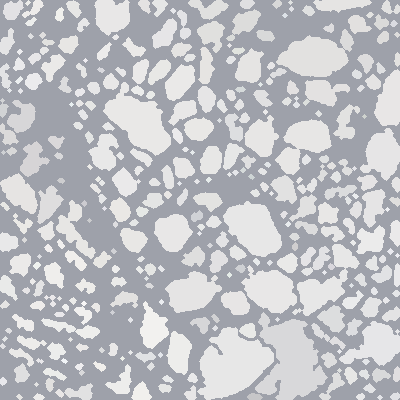

In [21]:
map(i -> segment_mean(segments, i), labels_map(segments))

With the falsecolor image:

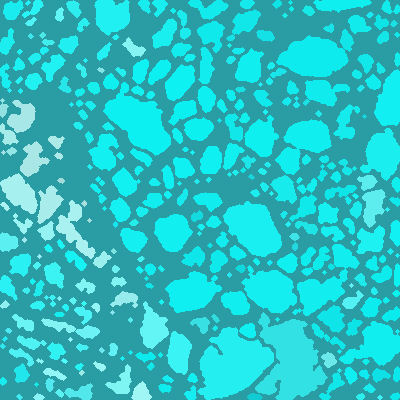

In [22]:
# Get the labels_map
segments_falsecolor = SegmentedImage(falsecolor, labels_map(segments))
map(i -> segment_mean(segments_falsecolor, i), labels_map(segments_falsecolor))

Let's compare the segmented output to the manually validated labels:

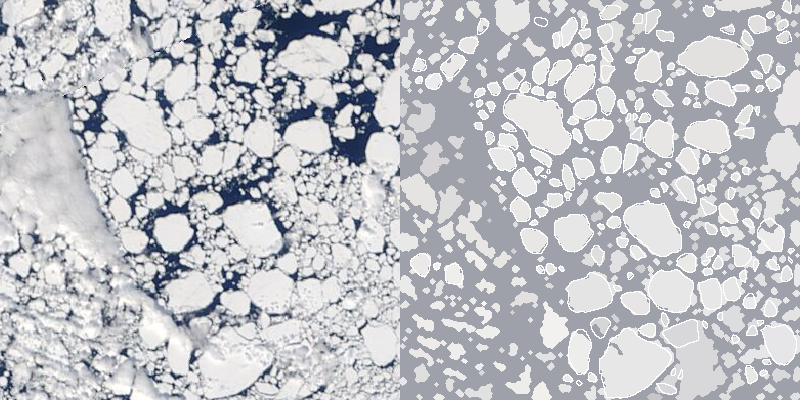

In [23]:
man_labels = validated_binary_floes(case)
outlines = man_labels .- erode(man_labels)
seg_vs = map(i -> segment_mean(segments, i), labels_map(segments))
mosaicview(truecolor, seg_vs .* (1 .- Float64.(outlines)), nrow=1)